In [100]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
from tpot import TPOTRegressor
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
from sklearn.inspection import permutation_importance

In [54]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [55]:
# Create a common region of interest
roi = ee.Geometry.Polygon([[[-121.39140625, 35.650331512181495],
          [-121.39140625, 30.687240701629882],
          [-112.7341796875, 30.687240701629882],
          [-112.7341796875, 35.650331512181495]]])

In [56]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8 = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P.addLayer(image_LANDSAT8, vis_params_L8, "Landsat-8")


In [57]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [58]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8_sep = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8_sep = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P_sep.addLayer(image_LANDSAT8_sep, vis_params_L8_sep, "Landsat-8")


In [59]:
#extract_band_values_from_shape_file_points
ground_truth= image_LANDSAT8.addBands(image_S5P)

work_dir = os.path.expanduser('/Users/mdnhuda/Desktop/PARC IEM Data/Correlation for Month with Scatter')
in_shp = os.path.join(work_dir, 'geometry_shape.shp')
in_fc = geemap.shp_to_ee(in_shp)
Map_S5P.addLayer(in_fc, {}, 'Shape FIle Geometry')

proj = ee.Projection('EPSG:4326')
reproj_image = ground_truth.resample('bilinear').reproject(crs=proj, scale=30)

out_csv = os.path.join(work_dir, 'Class_Including_LandSat8_S5_Los_Angeles July.csv')
geemap.extract_values_to_points(in_fc, reproj_image, out_csv)

df=pd.read_csv('Class_Including_LandSat8_S5_Los_Angeles July.csv')

Generating URL ...
Please wait ...
Data downloaded to /Users/mdnhuda/Desktop/PARC IEM Data/Correlation for Month with Scatter/Class_Including_LandSat8_S5_Los_Angeles July.csv


In [60]:
#traing data for September
ground_truth_sep= image_LANDSAT8_sep.addBands(image_S5P_sep)

work_dir = os.path.expanduser('/Users/mdnhuda/Desktop/PARC IEM Data/Correlation for Month with Scatter')
in_shp = os.path.join(work_dir, 'geometry_shape.shp')
in_fc = geemap.shp_to_ee(in_shp)
Map_S5P.addLayer(in_fc, {}, 'Shape FIle Geometry')

proj = ee.Projection('EPSG:4326')
reproj_image = ground_truth_sep.resample('bilinear').reproject(crs=proj, scale=30)

out_csv = os.path.join(work_dir, 'Class_Including_LandSat8_S5_Los_Angeles Sep.csv')
geemap.extract_values_to_points(in_fc, reproj_image, out_csv)

df=pd.read_csv('Class_Including_LandSat8_S5_Los_Angeles Sep.csv')
df_sep=pd.read_csv('Class_Including_LandSat8_S5_Los_Angeles Sep.csv')

Generating URL ...
Please wait ...
Data downloaded to /Users/mdnhuda/Desktop/PARC IEM Data/Correlation for Month with Scatter/Class_Including_LandSat8_S5_Los_Angeles Sep.csv


In [61]:
df

,Class,Lon,Lat,B10,B11,B1,B2,B3,B4,B5,NO2_column_number_density,B6,B7,sr_aerosol,system:index
0,water,-115.972790,33.443743,3109.195015,3087.726395,842.312071,1044.787353,1509.123743,1939.104107,2502.474880,0.000065,2990.463912,2550.758604,88.536095,0_0
1,water,-115.884899,33.333665,3113.189076,3089.824121,913.023541,1116.457239,1583.873728,2022.365271,2557.836908,0.000067,3054.755911,2623.292635,88.309103,1_0
2,water,-115.725597,33.292351,3120.365315,3094.859059,1013.505095,1222.073328,1706.343660,2175.074563,2655.039138,0.000067,3153.154534,2728.486537,86.796357,2_0
3,water,-115.780529,33.241828,3118.169294,3092.633592,1004.537087,1211.658380,1689.443634,2143.424092,2645.356259,0.000068,3153.365528,2730.360560,87.993503,3_0
4,water,-115.725597,33.172887,3121.010132,3093.948139,1069.360542,1279.557257,1764.937001,2226.648362,2712.511608,0.000069,3232.203554,2815.321498,88.186113,4_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,soil,-116.053294,34.539297,3177.926151,3157.997934,1256.829641,1492.843427,2047.696628,2529.979719,2933.436947,0.000067,3309.728500,3060.421429,114.074728,178_0
179,soil,-116.040934,34.552305,3176.957175,3157.086376,1261.337542,1497.386119,2054.274624,2539.827638,2948.101277,0.000067,3331.399234,3074.838195,113.431893,179_0
180,soil,-116.102045,34.642175,3174.097755,3154.405662,1210.173218,1445.433222,1997.508002,2469.025006,2885.452216,0.000066,3317.142165,3032.225119,113.565692,180_0
181,soil,-115.806788,34.552305,3170.831467,3151.268355,1400.865206,1639.444205,2228.824914,2776.204603,3225.383151,0.000066,3611.743127,3319.696371,105.885884,181_0


In [62]:
df_sep

,Class,Lon,Lat,B10,B11,B1,B2,B3,B4,B5,NO2_column_number_density,B6,B7,sr_aerosol,system:index
0,water,-115.972790,33.443743,3109.195015,3087.726395,842.312071,1044.787353,1509.123743,1939.104107,2502.474880,0.000065,2990.463912,2550.758604,88.536095,0_0
1,water,-115.884899,33.333665,3113.189076,3089.824121,913.023541,1116.457239,1583.873728,2022.365271,2557.836908,0.000067,3054.755911,2623.292635,88.309103,1_0
2,water,-115.725597,33.292351,3120.365315,3094.859059,1013.505095,1222.073328,1706.343660,2175.074563,2655.039138,0.000067,3153.154534,2728.486537,86.796357,2_0
3,water,-115.780529,33.241828,3118.169294,3092.633592,1004.537087,1211.658380,1689.443634,2143.424092,2645.356259,0.000068,3153.365528,2730.360560,87.993503,3_0
4,water,-115.725597,33.172887,3121.010132,3093.948139,1069.360542,1279.557257,1764.937001,2226.648362,2712.511608,0.000069,3232.203554,2815.321498,88.186113,4_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,soil,-116.053294,34.539297,3177.926151,3157.997934,1256.829641,1492.843427,2047.696628,2529.979719,2933.436947,0.000067,3309.728500,3060.421429,114.074728,178_0
179,soil,-116.040934,34.552305,3176.957175,3157.086376,1261.337542,1497.386119,2054.274624,2539.827638,2948.101277,0.000067,3331.399234,3074.838195,113.431893,179_0
180,soil,-116.102045,34.642175,3174.097755,3154.405662,1210.173218,1445.433222,1997.508002,2469.025006,2885.452216,0.000066,3317.142165,3032.225119,113.565692,180_0
181,soil,-115.806788,34.552305,3170.831467,3151.268355,1400.865206,1639.444205,2228.824914,2776.204603,3225.383151,0.000066,3611.743127,3319.696371,105.885884,181_0


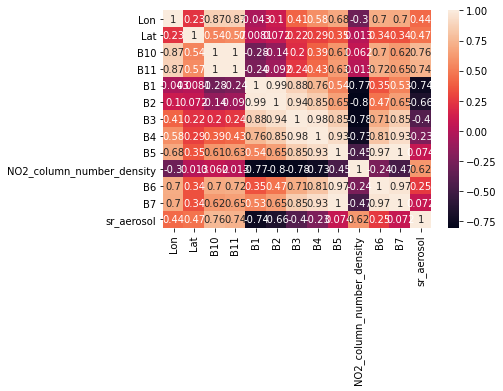

In [63]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

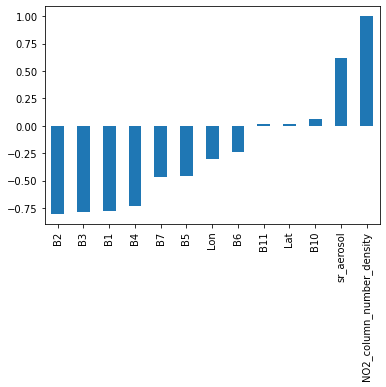

In [64]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

In [65]:
# use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['Class'], prefix='Class')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df.drop(['Class'],axis=1, inplace=True)

In [66]:
df

,Lon,Lat,B10,B11,B1,B2,B3,B4,B5,NO2_column_number_density,...,Class_forest,Class_grass,Class_highway,Class_industry,Class_land,Class_nodevelop,Class_ocean,Class_open_space,Class_soil,Class_water
0,-115.972790,33.443743,3109.195015,3087.726395,842.312071,1044.787353,1509.123743,1939.104107,2502.474880,0.000065,...,0,0,0,0,0,0,0,0,0,1
1,-115.884899,33.333665,3113.189076,3089.824121,913.023541,1116.457239,1583.873728,2022.365271,2557.836908,0.000067,...,0,0,0,0,0,0,0,0,0,1
2,-115.725597,33.292351,3120.365315,3094.859059,1013.505095,1222.073328,1706.343660,2175.074563,2655.039138,0.000067,...,0,0,0,0,0,0,0,0,0,1
3,-115.780529,33.241828,3118.169294,3092.633592,1004.537087,1211.658380,1689.443634,2143.424092,2645.356259,0.000068,...,0,0,0,0,0,0,0,0,0,1
4,-115.725597,33.172887,3121.010132,3093.948139,1069.360542,1279.557257,1764.937001,2226.648362,2712.511608,0.000069,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,-116.053294,34.539297,3177.926151,3157.997934,1256.829641,1492.843427,2047.696628,2529.979719,2933.436947,0.000067,...,0,0,0,0,0,0,0,0,1,0
179,-116.040934,34.552305,3176.957175,3157.086376,1261.337542,1497.386119,2054.274624,2539.827638,2948.101277,0.000067,...,0,0,0,0,0,0,0,0,1,0
180,-116.102045,34.642175,3174.097755,3154.405662,1210.173218,1445.433222,1997.508002,2469.025006,2885.452216,0.000066,...,0,0,0,0,0,0,0,0,1,0
181,-115.806788,34.552305,3170.831467,3151.268355,1400.865206,1639.444205,2228.824914,2776.204603,3225.383151,0.000066,...,0,0,0,0,0,0,0,0,1,0


In [67]:
# use pd.concat to join the new columns with your original dataframe
df_sep = pd.concat([df_sep,pd.get_dummies(df_sep['Class'], prefix='Class')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df_sep.drop(['Class'],axis=1, inplace=True)

In [68]:
df_sep

,Lon,Lat,B10,B11,B1,B2,B3,B4,B5,NO2_column_number_density,...,Class_forest,Class_grass,Class_highway,Class_industry,Class_land,Class_nodevelop,Class_ocean,Class_open_space,Class_soil,Class_water
0,-115.972790,33.443743,3109.195015,3087.726395,842.312071,1044.787353,1509.123743,1939.104107,2502.474880,0.000065,...,0,0,0,0,0,0,0,0,0,1
1,-115.884899,33.333665,3113.189076,3089.824121,913.023541,1116.457239,1583.873728,2022.365271,2557.836908,0.000067,...,0,0,0,0,0,0,0,0,0,1
2,-115.725597,33.292351,3120.365315,3094.859059,1013.505095,1222.073328,1706.343660,2175.074563,2655.039138,0.000067,...,0,0,0,0,0,0,0,0,0,1
3,-115.780529,33.241828,3118.169294,3092.633592,1004.537087,1211.658380,1689.443634,2143.424092,2645.356259,0.000068,...,0,0,0,0,0,0,0,0,0,1
4,-115.725597,33.172887,3121.010132,3093.948139,1069.360542,1279.557257,1764.937001,2226.648362,2712.511608,0.000069,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,-116.053294,34.539297,3177.926151,3157.997934,1256.829641,1492.843427,2047.696628,2529.979719,2933.436947,0.000067,...,0,0,0,0,0,0,0,0,1,0
179,-116.040934,34.552305,3176.957175,3157.086376,1261.337542,1497.386119,2054.274624,2539.827638,2948.101277,0.000067,...,0,0,0,0,0,0,0,0,1,0
180,-116.102045,34.642175,3174.097755,3154.405662,1210.173218,1445.433222,1997.508002,2469.025006,2885.452216,0.000066,...,0,0,0,0,0,0,0,0,1,0
181,-115.806788,34.552305,3170.831467,3151.268355,1400.865206,1639.444205,2228.824914,2776.204603,3225.383151,0.000066,...,0,0,0,0,0,0,0,0,1,0


It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

## ! Notes to Toyon !

- Can you run a multivariate regression model for this data, and document p-values?
- Can you run a machine learning model (e.g random forest/GBM) to fit this data? Document the feature importance. You can divide the data into train and test to see how well it performs within the month. 
- Can you test it on a different month (September 2018)? To see the divergence.
- Can you try generating the similar dataset for June 2018 using Sentinel-2 and Sentinel-5P data?
- Side note: we may have to generate additional spatial and temporal values (month, day of week, etc.) in the future to develop more precise models.

In [69]:
dtale.show(df)

In [70]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [71]:
X_sep=df_sep.drop('NO2_column_number_density',axis=1).values
y_sep=df_sep['NO2_column_number_density'].values

X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X_sep, y_sep, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train_sep=scaler.fit_transform(X_train_sep)
X_test_sep=scaler.transform(X_test_sep)

In [110]:
#cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
#model = TPOTRegressor(generations=4, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=42, n_jobs=-1)
#model.fit(X_train, y_train)

Warning: xgboost.XGBRegressor is not available and will not be used by TPOT.

Generation 1 - Current best internal CV score: -8.706239211729272e-07

Generation 2 - Current best internal CV score: -8.321376909105996e-07

Generation 3 - Current best internal CV score: -8.321376909105996e-07

Generation 4 - Current best internal CV score: -8.321376909105996e-07

## Best pipeline: ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.55, min_samples_leaf=2, ##min_samples_split=5, n_estimators=100)
## TPOTRegressor(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
               generations=4, n_jobs=-1, population_size=50, random_state=42,
               scoring='neg_mean_absolute_error', verbosity=2)

In [113]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(bootstrap=False, max_features=0.55, min_samples_leaf=2, min_samples_split=5, n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor(max_features=0.55, min_samples_leaf=2, min_samples_split=5)

In [116]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.993
Test Accuracy : 0.987


In [112]:
#model.export('tpot_best_model.py')

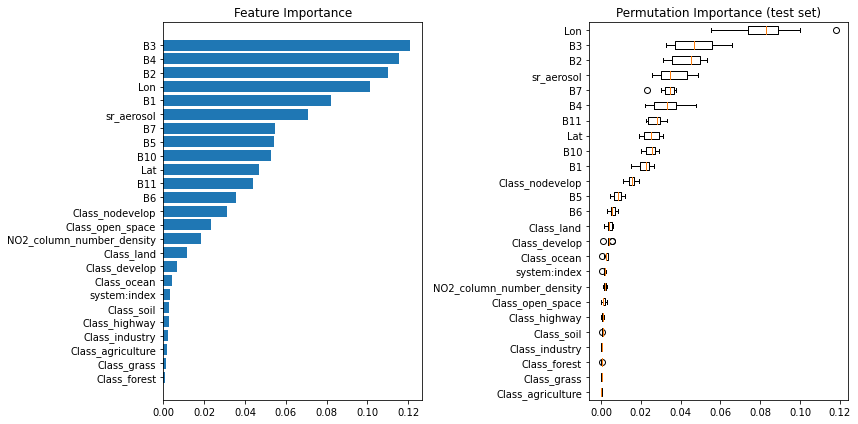

In [115]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Mean Squared Error = 6.514088252939068e-13
Mean absolute percentage error = 0.006019569847100794


Text(0, 0.5, 'NO2_column_number_density')

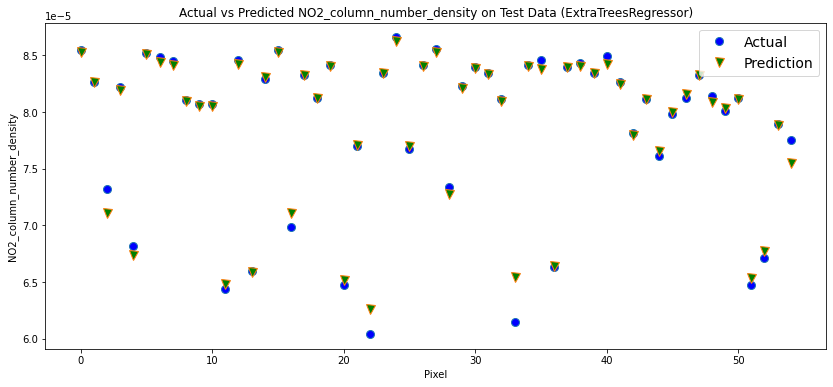

In [118]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (ExtraTreesRegressor)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 6.514088252939068e-13
Mean absolute percentage error = 0.006019569847100794


Text(0, 0.5, 'NO2_column_number_density')

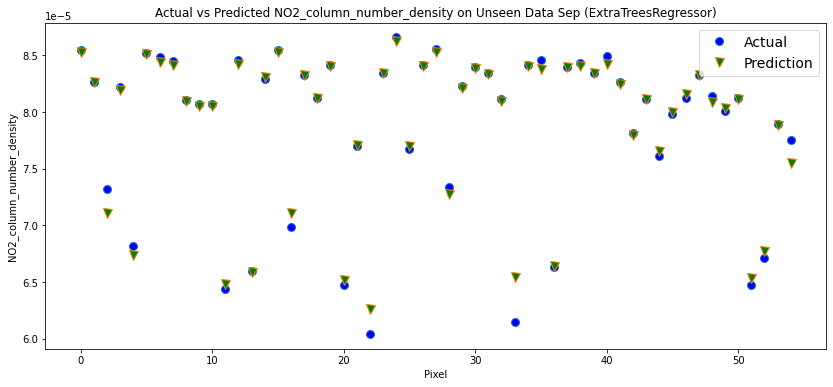

Text(0, 0.5, 'NO2_column_number_density')

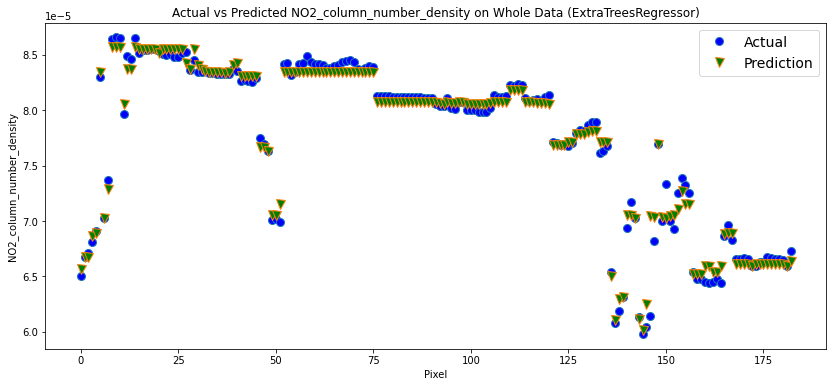

In [119]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (ExtraTreesRegressor)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

## Additional Methods follows below

In [ ]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15],
            'max_depth': [5,10,20]
        }
    },
}

In [ ]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

In [ ]:
#Rainforest Regression
model = RandomForestRegressor(n_estimators=5, max_depth=5,
                                random_state=2)
model.fit(X_train,y_train)

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

In [ ]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
NO2_column_number_density=df['NO2_column_number_density']

In [ ]:
X_all=scaler.transform(X)
all_prediction=model.predict(X_all)

In [ ]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [ ]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

In [ ]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [ ]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

# Linear Regression 

In [ ]:
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction

##
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')


logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

# k-Nearest Neighbors for Multioutput Regression

In [ ]:
# define model
model = KNeighborsRegressor(leaf_size= 1, p= 1 ,n_neighbors= 1)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction

##
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')


logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

In [ ]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsRegressor()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X,y)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

# Decision Tree for Multioutput Regression

In [ ]:
# define model
model = DecisionTreeRegressor(max_depth=6,
                           min_samples_split=40,
                           max_leaf_nodes=100,
                              min_samples_leaf= 20)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction

##
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')


logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

In [ ]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

In [ ]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

## Comment in order to publish in kaggle.

grid_cv_dtm = GridSearchCV(model, param_grid, cv=5)

grid_cv_dtm.fit(X,y)

print("R-Squared::{}".format(grid_cv_dtm.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(alpha=0.85, learning_rate=0.5, loss='lad', max_depth=10, max_features=0.9500000000000001,
                                min_samples_leaf=10, min_samples_split=5, n_estimators=50, subsample=0.6500000000000001)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

In [ ]:
param_grid = {"alpha": [0.5,0.85],
              "learning_rate": [0.5,0.85],
              "max_depth": [5, 10, 15,20,25],
              "min_samples_leaf": [10,20, 40, 100],
              "min_samples_split": [5, 20, 100],
              "n_estimators": [10,20,50,100]
              }

## Comment in order to publish in kaggle.

grid_cv_dtm = GridSearchCV(model, param_grid, cv=5)

grid_cv_dtm.fit(X,y)

print("R-Squared::{}".format(grid_cv_dtm.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))